#Samer Baslan
#CMPE-297 Assignment 1 Part (a)
#SimCLR PyTorch implementation

Resource: https://github.com/thunderInfy/simclr

##Download Data

In [1]:
!rm -rf imagenet-5-categories
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 29.67 MiB/s, done.
Resolving deltas: 100% (1/1), done.


##Imports

In [35]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from collections import OrderedDict
from imutils import paths
from PIL import Image
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
DEVICE = torch.device('cuda')

##Helper Classes

In [4]:
class TrainDataset(torch.utils.data.Dataset):
  def __init__(self, data):
    self.data = data
    self.train_images = train_images

  def __len__(self):
    return(len(self.train_images))

  def tensorify(self, img):
    return torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(
        torchvision.transforms.ToTensor()(img)
    )

  def augmented_image(self, img, s = 1):
    color_jitter = torchvision.transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
    rnd_color_jitter = torchvision.transforms.RandomApply([color_jitter], p = 0.8)
    rnd_gray = torchvision.transforms.RandomGrayscale(p = 0.2)
    color_distort = torchvision.transforms.Compose([rnd_color_jitter, rnd_gray])
    return color_distort(
        torchvision.transforms.RandomResizedCrop(224)(img)
    )

  def __getitem__(self, idx):
    img = torchvision.transforms.Resize((224, 224))(
        Image.open(self.train_images[idx]).convert("RGB")
    )
    return {
        "image1": self.tensorify(
            self.augmented_image(img)
        ),
        "image2": self.tensorify(
            self.augmented_image(img)
        )
    }

In [5]:
class SimCLR:
  def __init__(self, model, optimizer, data_loaders, loss_fn):
    self.model = model
    self.optimizer = optimizer
    self.data_loaders = data_loaders
    self.loss_fn = loss_fn

  def train(self, num_epochs):
    batch_loss = []
    epoch_loss = []

    self.model.train()

    for epoch in range(num_epochs):
      for batch in self.data_loaders:
        self.optimizer.zero_grad()
        x1 = batch['image1'].to(DEVICE)
        x2 = batch['image2'].to(DEVICE)
        y1 = self.model(x1)
        y2 = self.model(x2)
        loss = self.loss_fn(y1, y2)
        batch_loss.append(loss.cpu().data.item())
        #perform backprop on loss value to get gradient values
        loss.backward()
        #run the optimizer
        self.optimizer.step()
      epoch_loss.append(np.mean(batch_loss))
      print(f"epoch = {epoch + 1}, loss = {epoch_loss[-1]}")
    return epoch_loss

##Helper Functions

In [6]:
def get_model():
  resnet = resnet18(pretrained = False)

  head = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(resnet.fc.in_features, 100)),
        ('added_relu1', nn.ReLU(inplace = True)),
        ('fc2', nn.Linear(100, 100)),
        ('added_relu2', nn.ReLU(inplace = True)),
        ('fc3', nn.Linear(100, 100))
  ]))

  resnet.fc = head
  resnet.to(DEVICE)

  return resnet

In [7]:
def loss(a, b):
  tau = 0.05
  a_norm = torch.norm(a, dim=1).reshape(-1, 1)
  a_cap = torch.div(a, a_norm)
  b_norm = torch.norm(b, dim=1).reshape(-1, 1)
  b_cap = torch.div(b, b_norm)
  a_cap_b_cap = torch.cat([a_cap, b_cap], dim=0)
  a_cap_b_cap_transpose = torch.t(a_cap_b_cap)
  b_cap_a_cap = torch.cat([b_cap, a_cap], dim=0)
  sim = torch.mm(a_cap_b_cap, a_cap_b_cap_transpose)
  sim_by_tau = torch.div(sim, tau)
  exp_sim_by_tau = torch.exp(sim_by_tau)
  sum_of_rows = torch.sum(exp_sim_by_tau, dim=1)
  exp_sim_by_tau_diag = torch.diag(exp_sim_by_tau)
  numerators = torch.exp(torch.div(torch.nn.CosineSimilarity()(a_cap_b_cap, b_cap_a_cap), tau))
  denominators = sum_of_rows - exp_sim_by_tau_diag
  num_by_den = torch.div(numerators, denominators)
  neg_log_num_by_den = -torch.log(num_by_den)
  return torch.mean(neg_log_num_by_den)

##Run model

In [10]:
train_images = list(paths.list_images("imagenet-5-categories/train"))
model = get_model()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 1e-4)
data_loader = torch.utils.data.DataLoader(TrainDataset(train_images), batch_size = 32, shuffle = True, num_workers = 2)
epoch_loss = SimCLR(model, optimizer, data_loader, loss).train(10)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch = 1, loss = 4.037615859508515
epoch = 2, loss = 4.010408767312765
epoch = 3, loss = 3.984715875486533
epoch = 4, loss = 3.972729215398431
epoch = 5, loss = 3.9657945108413695
epoch = 6, loss = 3.953844590485096
epoch = 7, loss = 3.949254758443151
epoch = 8, loss = 3.9364465905353425
epoch = 9, loss = 3.937958250277572
epoch = 10, loss = 3.92671745095402


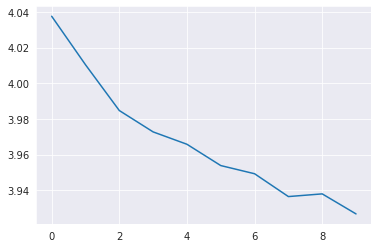

In [33]:
plt.plot(epoch_loss)
sns.set_style('darkgrid')